## House Price and Crime Rate comparison of London Boroughs (2017)

### Data Sources

##### London Crime data by borough from Sept 2016 - Aug 2018
https://data.london.gov.uk/dataset/recorded_crime_summary


##### London House Prices data by borough from Jan 2016 - July 2018
https://data.london.gov.uk/dataset/uk-house-price-index


##### Population of London boroughs (Estimate Jun 2017)
https://www.citypopulation.de/php/uk-greaterlondon.php

### Import Libraries and Load Data

In [1]:
%matplotlib notebook

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Math

plt.get_backend()

'nbAgg'

In [3]:
# Load data
crime_raw_df = pd.read_csv('./data/MPS Borough Level Crime.csv')
house_price_raw_df = pd.read_excel('./data/UK House price index.xls', sheet_name='Average price')
pop_raw_df = pd.read_excel('./data/london_borough_population.xlsx', header=1)

### Format Crime Data

In [4]:
def format_crime_data(df):
    """
    Crime Data: Performs clean up and aggregate steps on
    Returns a series
    
    """
    # Keep only the required columns
    keep_columns = [
        'Borough',
        '201701', '201702', '201703', '201704', '201705', '201706',
        '201707', '201708', '201709', '201710', '201711', '201712',
    ]
    df = df[keep_columns]

    # Set borough as the index
    df = df.set_index('Borough')

    # Drop Heathrow borough rows
    df = df.drop('London Heathrow and London City Airports', axis=0) 

    # Get the total crimes of 2017
    df = df.sum(axis=1)

    # Group all crime categories and find sum
    df = df.groupby(df.index).agg('sum')
    
    df.name = 'Total Crime'
    
    return df
    
crime_df = format_crime_data(crime_raw_df)

### Format House Price Data

In [5]:
def format_house_price_data(df):
    """
    House Price data: Performs clean up and aggregate steps on
    Returns a series
    
    """
    # Get rows for 2017
    df = df.loc['2017-01-01': '2017-12-01']
    
    # Keep the required rows and columns
    columns = [
        'Barking & Dagenham', 'Barnet', 'Bexley', 'Brent',
        'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield', 'Greenwich',
        'Hackney', 'Hammersmith & Fulham', 'Haringey', 'Harrow', 'Havering',
        'Hillingdon', 'Hounslow', 'Islington', 'Kensington & Chelsea',
        'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham',
        'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton',
        'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster'
    ]
    df = df[columns]
    
    df.columns = map(lambda x: x.replace('&', 'and'), df.columns)
    
    # Get borough names as index
    df = df.T    
    
    # Get the mean house price for 2017
    df = df.mean(axis=1)
    
    # Convert float to int
    df = df.astype('int')
    
    df.name = 'Average House Price'

    return df
    
house_price_df = format_house_price_data(house_price_raw_df)

### Format Population data

In [6]:
def format_population_data(df):
    """
    Population data: Performs clean up and aggregate steps on 
    Returns a series
    
    """
    # 'City of Westminster' is called 'Westminster' in other tables
    df['Borough'] = df['Borough'].replace('City of Westminster', 'Westminster')
    df = df.set_index('Borough')
    return df

pop_df = format_population_data(pop_raw_df)

### Merge Crime, House Price and Population data into one table

In [7]:
final_df = pd.concat([house_price_df, crime_df, pop_df], axis=1, sort=True)
final_df.head()

,Average House Price,Total Crime,Population
Barking and Dagenham,287708,18671,210711
Barnet,538128,26989,387803
Bexley,335742,14815,246124
Brent,487991,29741,329102
Bromley,441077,22774,329391


### Get Crime Rate

In [8]:
# Get Crime per 1000 residents (rounded to whole number)
final_df['Crime Rate'] = round( (final_df['Total Crime']/final_df['Population']) * 1000 , 0)
final_df['Crime Rate'] = final_df['Crime Rate'].astype('int')
final_df.head()

,Average House Price,Total Crime,Population,Crime Rate
Barking and Dagenham,287708,18671,210711,89
Barnet,538128,26989,387803,70
Bexley,335742,14815,246124,60
Brent,487991,29741,329102,90
Bromley,441077,22774,329391,69


### Add Colour column

In [9]:
def add_colour(df):
    colours = [
        '#5DFF29', # Green
        '#FF9B51', # Orange
        '#FF3F3F', # Red
    ]
    h_avg = df['Average House Price'].mean()
    c_avg = df['Crime Rate'].mean()
    
    # Fill Colours column with correct colours
    df.loc[(df['Average House Price'] <= h_avg) & (df['Crime Rate'] <= c_avg), 'Colours'] = colours[0]
    df.loc[(df['Average House Price'] < h_avg) & (df['Crime Rate'] > c_avg), 'Colours'] = colours[1]
    df.loc[(df['Average House Price'] > h_avg) & (df['Crime Rate'] < c_avg), 'Colours'] = colours[1]
    df.loc[(df['Average House Price'] > h_avg) & (df['Crime Rate'] > c_avg), 'Colours'] = colours[2]

    return df

final_df = add_colour(final_df)
final_df.head()

,Average House Price,Total Crime,Population,Crime Rate,Colours
Barking and Dagenham,287708,18671,210711,89,#5DFF29
Barnet,538128,26989,387803,70,#FF9B51
Bexley,335742,14815,246124,60,#5DFF29
Brent,487991,29741,329102,90,#5DFF29
Bromley,441077,22774,329391,69,#5DFF29


### Get arrays for plotting

In [10]:
# Returns an array of mean value with same shape as input
avg = lambda series: np.full(series.shape[0], int(series.mean()))

# Mean House Price array
house_price_avg = avg(final_df['Average House Price'])

# Mean Crime Rate array
crime_rate_avg = avg(final_df['Crime Rate'])
house_price_avg

array([528882, 528882, 528882, 528882, 528882, 528882, 528882, 528882,
       528882, 528882, 528882, 528882, 528882, 528882, 528882, 528882,
       528882, 528882, 528882, 528882, 528882, 528882, 528882, 528882,
       528882, 528882, 528882, 528882, 528882, 528882, 528882, 528882])

<IPython.core.display.Javascript object>


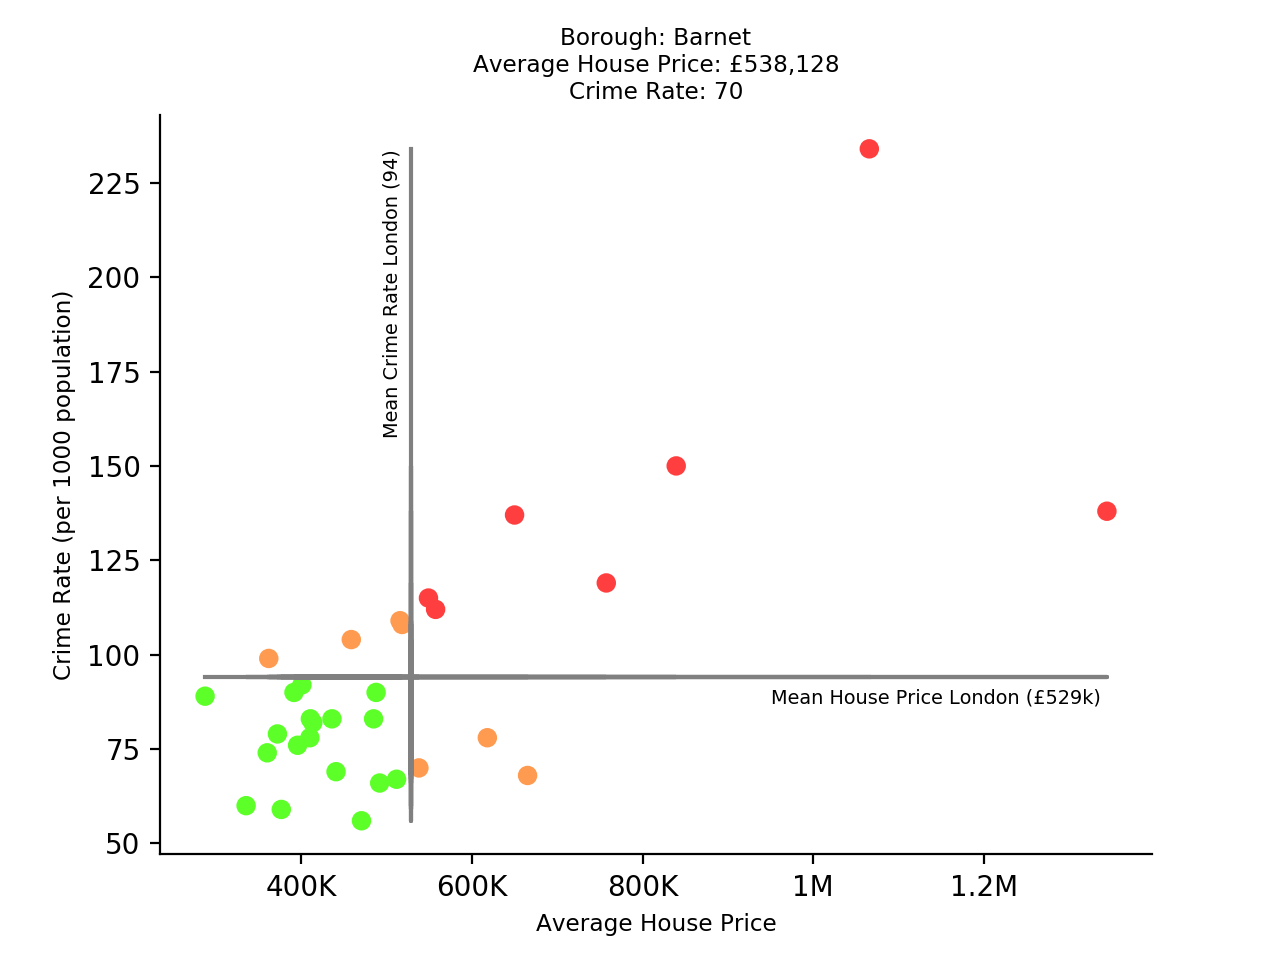

In [15]:
plt.figure()
# plt.axis('off')

plt.scatter(final_df['Average House Price'], final_df['Crime Rate'], color=final_df['Colours'], picker=5, marker='o')

# Draw mean lines for house price and crime Rate
plt.plot(final_df['Average House Price'], crime_rate_avg, color='grey')
plt.plot(house_price_avg, final_df['Crime Rate'], color='grey', label='HEYY')

# Label House Price mean line
h_text = 'Mean House Price London (£529k)'
plt.text(9.5*10**5, 87, h_text, fontsize='x-small')

# Label Crime mean line
v_text = 'Mean Crime Rate London ({})'.format(crime_rate_avg[0])
plt.text(495000, 230, v_text, fontsize='x-small', rotation='vertical')

title = 'Click on the point to see Borough name'
plt.gca().set_title(title, fontsize='medium')

plt.xlabel('Average House Price', fontsize='small')
plt.ylabel('Crime Rate (per 1000 population)', fontsize='small')

# Remove top and right border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Label the x-axis with easy to read values
tick_label_list = ['', '400K', '600K', '800K', '1M', '1.2M', '']
plt.gca().set_xticklabels(tick_label_list)

def onpick(event):
    borough = final_df.iloc[event.ind[0]].name
    price = final_df.iloc[event.ind[0]]['Average House Price']
    crime = final_df.iloc[event.ind[0]]['Crime Rate']
    plt.gca().set_title(
        'Borough: {}\nAverage House Price: £{:,}\nCrime Rate: {}'.format(borough, price, crime),
        fontsize='small',
    )

# tell mpl_connect we want to pass a 'pick_event' into onpick when the event is detected
plt.gcf().canvas.mpl_connect('pick_event', onpick);
plt.savefig('HousePrice_CrimeRate_by_London_Borough.png')